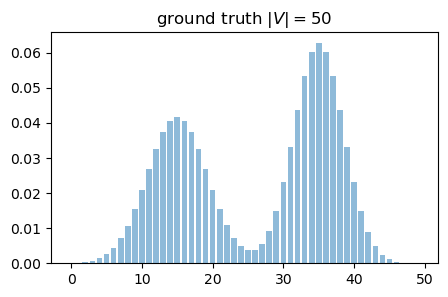

In [1]:
import numpy as np
import matplotlib.pyplot as plt

K = 50
peaks = [15, 35]

p0 = np.ones(K)
for k in range(K):
    p0[k] = 0.4 * np.exp(-(k-peaks[0])**2 / 36) + 0.6 * np.exp(-(k-peaks[1])**2 / 25)

p0 = p0 / p0.sum()

mu0 = np.sum(p0 * range(K))
mode0 = np.argmax(p0)

fig, ax = plt.subplots(figsize=(5,3))
plt.bar(range(K), p0/p0.sum(), alpha=0.5)
plt.title('ground truth $|V|=50$')
plt.show()

In [8]:
def generate_data(n, p):
    X = np.random.multinomial(n, p)
    return X

def estimate_p_MLE(X):
    # X is already the counts -> multinomial
    return X / X.sum()

def metric_p2(p0, phat):
    return np.sum((p0 - phat)**2)

def metric_p1(p0, phat):
    return np.sum(np.abs(p0 - phat))

def plot_avg(loss, ax):
    mean = np.mean(loss, axis=0)
    var = np.var(loss, axis=0)
    for i in range(len(loss)):
        ax.plot(range(loss.shape[1]), loss[i], color='yellow', alpha=0.1)
    ax.plot(range(loss.shape[1]), mean)
    #ax.fill_between(range(loss.shape[1]), mean-var, mean+var, alpha=0.7)

## Simulation 1 - Existing Analysis

In this case, we focus on the situation where no fresh data comes from the ground truth in successive rounds. We consider three regimes
1. Fixed sample size $n$ for each iteration (only synthetic from last model) - total collapse
2. Super-linearly increasing $n_t \approx \beta * t^{3/2}$
3. Fixed $n$ new synthetic from last model but accumulated across all previous rounds (so $n_t=\beta t$)

In [5]:
def iterative_histogram_syn(p0, beta, T, fixed=True, accu=False):
    K = len(p0)
    n = beta
    
    # first iteration
    X = np.random.multinomial(n, p0)
    phat = estimate_p_MLE(X) 

    loss_p1 = [metric_p1(p0, phat)]
    loss_p2 = [metric_p2(p0, phat)]
    
    
    for t in range(T-1):
        if fixed is False:
            n = int(beta * (1+t)**1.5)
        X1 = np.random.multinomial(n, phat)
        
        if accu is True:
            X = X + X1
            phat = estimate_p_MLE(X) 
        else:
            phat = estimate_p_MLE(X1)
            
        loss_p1.append(metric_p1(p0, phat))
        loss_p2.append(metric_p2(p0, phat))
        
    return loss_p1, loss_p2

In [6]:
reps = 1000
T = 300

from tqdm import tqdm
from joblib import Parallel, delayed

# fixed n
def f(i):
    return iterative_histogram_syn(p0, beta=40, T=T, fixed=True, accu=False)

results_syn1 = Parallel(n_jobs=-1)(delayed(f)(i) for i in range(reps))
print('fixed n finished')

# n growing
def f(i):
    return iterative_histogram_syn(p0, beta=40, T=T, fixed=False, accu=False)

results_syn2 = Parallel(n_jobs=-1)(delayed(f)(i) for i in range(reps))
print('inc n finished')

# accumulation
def f(i):
    return iterative_histogram_syn(p0, beta=40, T=T, fixed=True, accu=True)

results_syn3 = Parallel(n_jobs=-1)(delayed(f)(i) for i in range(reps))
print('accumulation finished')

fixed n finished
inc n finished
accumulation finished


In [7]:
syn1_loss_p1 = np.array([results_syn1[i][0] for i in range(reps)]) # shape (reps, T)
syn1_loss_p2 = np.array([results_syn1[i][1] for i in range(reps)])

syn2_loss_p1 = np.array([results_syn2[i][0] for i in range(reps)]) # shape (reps, T)
syn2_loss_p2 = np.array([results_syn2[i][1] for i in range(reps)])

syn3_loss_p1 = np.array([results_syn3[i][0] for i in range(reps)]) # shape (reps, T)
syn3_loss_p2 = np.array([results_syn3[i][1] for i in range(reps)])

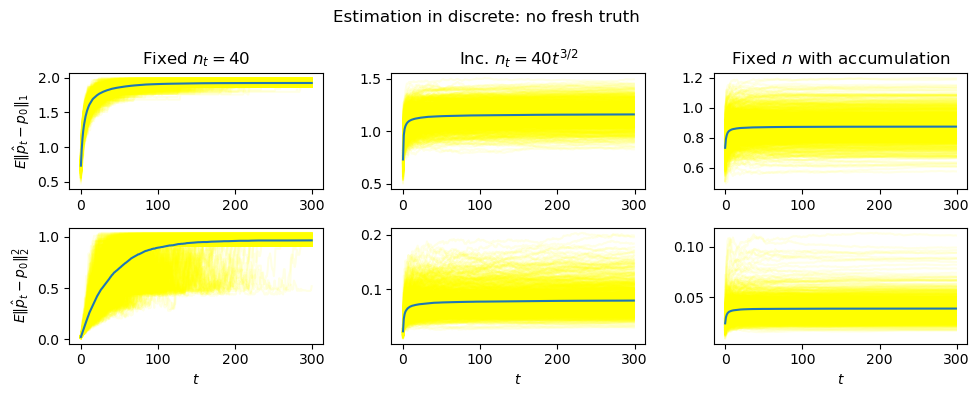

In [11]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10,4))

plot_avg(syn1_loss_p1, ax[0,0])
plot_avg(syn2_loss_p1, ax[0,1])
plot_avg(syn3_loss_p1, ax[0,2])

plot_avg(syn1_loss_p2, ax[1,0])
plot_avg(syn2_loss_p2, ax[1,1])
plot_avg(syn3_loss_p2, ax[1,2])


ax[0,0].set_ylabel('$E\Vert \hat{p}_t - p_0\Vert_1$')
ax[1,0].set_ylabel('$E\Vert \hat{p}_t - p_0\Vert_2^2$')

ax[0,0].set_title('Fixed $n_t=40$')
ax[0,1].set_title('Inc. $n_t=40 t^{3/2}$')
ax[0,2].set_title('Fixed $n$ with accumulation')
for i in range(3):
    ax[1,i].set_xlabel('$t$')
    
plt.suptitle('Estimation in discrete: no fresh truth')
plt.tight_layout()
plt.show()

## Simulation 2 - New Analysis

In this case, we focus on the situation where fresh data comes from the ground truth in successive rounds. We consider $n_t=\beta t$ linearly increasing sample size. The mixture probability corresponding to truth is $\alpha_t$. We consider the following scenarios.

1. $\alpha_t = 0$ (no truth)
2. $\alpha_t \approx 1/t$
3. $\alpha_t \approx 1/\sqrt{t}$
4. $\alpha_t \approx 1/t^{1/3}$
5. $\alpha_t>0$ fixed

In [49]:
def iterative_learning_histogram(p0, n0, T, alpha, gamma=0.0, beta=40):
    '''
    p_t = alpha_t * p0 + (1-alpha_t) * p_hat
    
    beta -> linear rate of sample size
    sample size n_t = n0 + beta * t linearly increasing
    
    gamma -> decay rate for alpha
    alpha_t = alpha / t**gamma
    '''
    K = len(p0)
    
    # first iteration
    X = np.random.multinomial(n0, p0)
    phat = estimate_p_MLE(X) # can change this to some other estimator
    
    loss_p1 = [metric_p1(p0, phat)]
    loss_p2 = [metric_p2(p0, phat)]
    
    for t in range(T-1):
        alpha_t = alpha / (t+1)**gamma
        prop = np.array([alpha_t, 1-alpha_t])
        m = np.random.multinomial(int(n0 + beta*(t+1)), prop)
        X1 = np.random.multinomial(m[0], p0)
        X2 = np.random.multinomial(m[1], phat)
        X = X1 + X2
        
        phat = estimate_p_MLE(X) # can change this to some other estimator
        
        loss_p1.append(metric_p1(p0, phat))
        loss_p2.append(metric_p2(p0, phat))
        
    return loss_p1, loss_p2


In [51]:
reps = 1000
T = 300

from tqdm import tqdm
from joblib import Parallel, delayed

# fully synthetic
def f(i):
    return iterative_learning_histogram(p0, n0=40, T=T, alpha=0.0, gamma=0.0)

results_syn = Parallel(n_jobs=-1)(delayed(f)(i) for i in range(reps))
print('synthetic finished')

# fixed truth
def f(i):
    return iterative_learning_histogram(p0, n0=40, T=T, alpha=0.1, gamma=0.0)

results_fix = Parallel(n_jobs=-1)(delayed(f)(i) for i in range(reps))
print('fixed finished')

# alpha_t ~ 1/t^0.33
def f(i):
    return iterative_learning_histogram(p0, n0=40, T=T, alpha=0.1, gamma=0.33)

results_3 = Parallel(n_jobs=-1)(delayed(f)(i) for i in range(reps))
print('1/3 decay rate finished')

# alpha_t ~ 1/t^0.5
def f(i):
    return iterative_learning_histogram(p0, n0=40, T=T, alpha=0.1, gamma=0.5)

results_2 = Parallel(n_jobs=-1)(delayed(f)(i) for i in range(reps))
print('1/2 decay rate finished')

# alpha_t ~ 1/t
def f(i):
    return iterative_learning_histogram(p0, n0=40, T=T, alpha=0.1, gamma=1.0)

results_1 = Parallel(n_jobs=-1)(delayed(f)(i) for i in range(reps))
print('linear decay rate finished')

synthetic finished
fixed finished
1/3 decay rate finished
1/2 decay rate finished
linear decay rate finished


In [52]:
syn_loss_p1 = np.array([results_syn[i][0] for i in range(reps)]) # shape (reps, T)
syn_loss_p2 = np.array([results_syn[i][1] for i in range(reps)])

fix_loss_p1 = np.array([results_fix[i][0] for i in range(reps)]) # shape (reps, T)
fix_loss_p2 = np.array([results_fix[i][1] for i in range(reps)])

dec3_loss_p1 = np.array([results_3[i][0] for i in range(reps)]) # shape (reps, T)
dec3_loss_p2 = np.array([results_3[i][1] for i in range(reps)])

dec2_loss_p1 = np.array([results_2[i][0] for i in range(reps)]) # shape (reps, T)
dec2_loss_p2 = np.array([results_2[i][1] for i in range(reps)])

dec1_loss_p1 = np.array([results_1[i][0] for i in range(reps)]) # shape (reps, T)
dec1_loss_p2 = np.array([results_1[i][1] for i in range(reps)])

In [55]:
def plot_avg(loss, ax):
    mean = np.mean(loss, axis=0)
    var = np.var(loss, axis=0)
    for i in range(len(loss)):
        ax.plot(range(loss.shape[1]), loss[i], color='yellow', alpha=0.1)
    ax.plot(range(loss.shape[1]), mean)
    #ax.fill_between(range(loss.shape[1]), mean-var, mean+var, alpha=0.7)

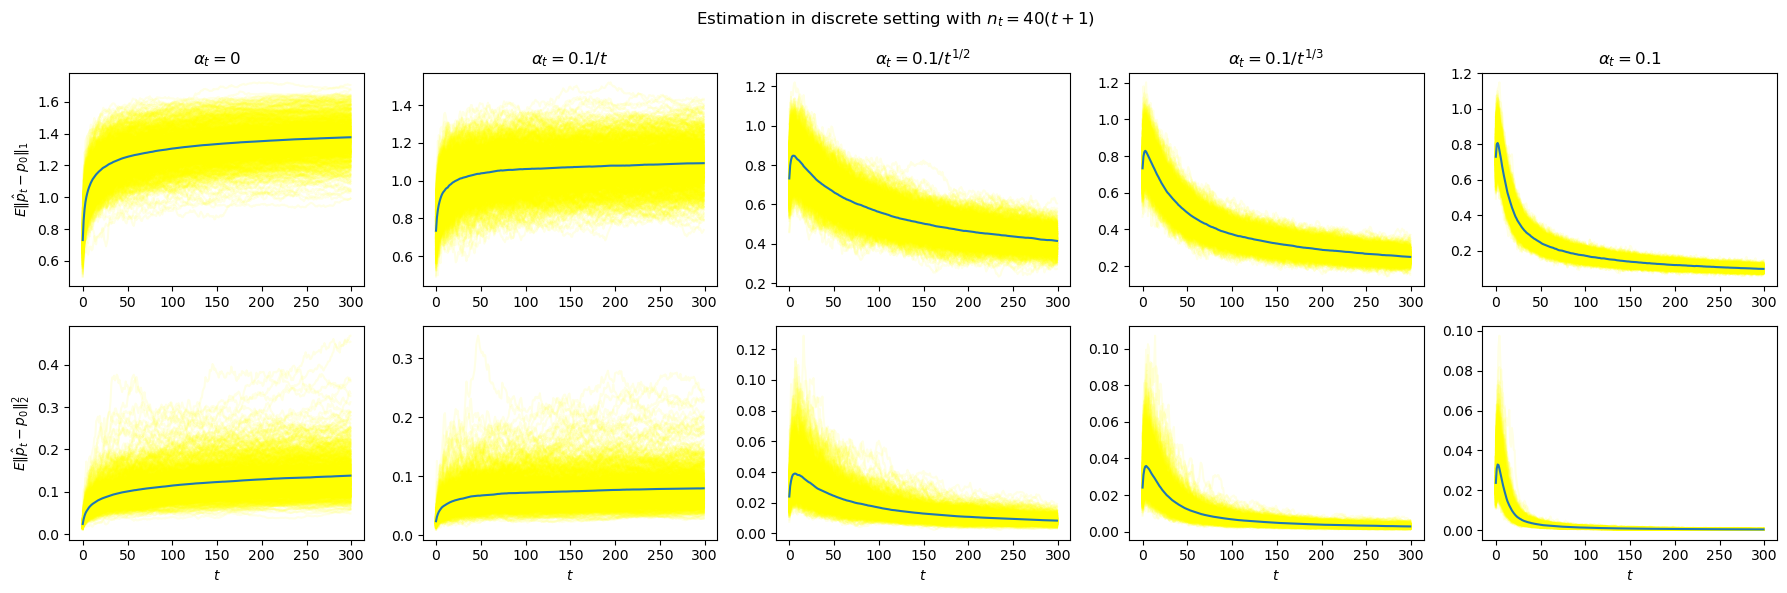

In [56]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(18,6))

plot_avg(syn_loss_p1, ax[0,0])
plot_avg(dec1_loss_p1, ax[0,1])
plot_avg(dec2_loss_p1, ax[0,2])
plot_avg(dec3_loss_p1, ax[0,3])
plot_avg(fix_loss_p1, ax[0,4])

plot_avg(syn_loss_p2, ax[1,0])
plot_avg(dec1_loss_p2, ax[1,1])
plot_avg(dec2_loss_p2, ax[1,2])
plot_avg(dec3_loss_p2, ax[1,3])
plot_avg(fix_loss_p2, ax[1,4])

ax[0,0].set_ylabel('$E\Vert \hat{p}_t - p_0\Vert_1$')
ax[1,0].set_ylabel('$E\Vert \hat{p}_t - p_0\Vert_2^2$')

ax[0,0].set_title('$\\alpha_t=0$')
ax[0,1].set_title('$\\alpha_t=0.1/t$')
ax[0,2].set_title('$\\alpha_t=0.1/t^{1/2}$')
ax[0,3].set_title('$\\alpha_t=0.1/t^{1/3}$')
ax[0,4].set_title('$\\alpha_t=0.1$')
for i in range(5):
    ax[1,i].set_xlabel('$t$')
    
plt.suptitle('Estimation in discrete setting with $n_t=40(t+1)$')
plt.tight_layout()
plt.show()